In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from lightgbm import LGBMClassifier

from pycaret.classification import setup, evaluate_model, compare_models, plot_model

import optuna

C:\Users\Anes3\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Data

In [2]:
train = pd.read_csv('train.csv', index_col='id')
test = pd.read_csv('test.csv', index_col='id')

In [3]:
train.shape

(414, 7)

In [4]:
train.head()

,gravity,ph,osmo,cond,urea,calc,target
id,,,,,,,
0,1.013,6.19,443,14.8,124,1.45,0
1,1.025,5.40,703,23.6,394,4.18,0
2,1.009,6.13,371,24.5,159,9.04,0
3,1.021,4.91,442,20.8,398,6.63,1
4,1.021,5.53,874,17.8,385,2.21,1


In [5]:
train.target.value_counts()

0    230
1    184
Name: target, dtype: int64

In [6]:
X = train.drop('target', axis=1).copy()
y = train.target

# Feature Scaling

In [7]:
#First we need to combine train and test, scale then split again
X1 = pd.concat([X, test])

scaler = StandardScaler()
X2 = pd.DataFrame(scaler.fit_transform(X1) ,columns = X.columns)

X = X2.iloc[:len(train), :]
test = X2.iloc[len(train):, :]

# Base Model

In [8]:
rf = RandomForestClassifier(random_state=0)

results = []

kf = KFold(n_splits=10, shuffle=True, random_state=0)

r = cross_val_score(rf, X, y, scoring='roc_auc')

results.append(r)

print(f'ROC score: {np.mean(results).round(2)}')

ROC score: 0.78


# Model Selection

In [9]:
_ = setup(data=train, target='target')

,Description,Value
0,session_id,3777
1,Target,target
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(414, 7)"
5,Missing Values,False
6,Numeric Features,6
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [10]:
best = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7333,0.7995,0.6583,0.6999,0.6642,0.4456,0.4545,0.1690
et,Extra Trees Classifier,0.6988,0.7858,0.6192,0.6536,0.6278,0.3768,0.3814,0.1650
lda,Linear Discriminant Analysis,0.7333,0.7769,0.5776,0.7549,0.6329,0.4338,0.4558,0.0030
lr,Logistic Regression,0.7367,0.7758,0.5942,0.7352,0.6468,0.4441,0.4561,0.3760
gbc,Gradient Boosting Classifier,0.6916,0.7728,0.6442,0.6457,0.6394,0.3701,0.3755,0.0130
lightgbm,Light Gradient Boosting Machine,0.7090,0.7722,0.6436,0.6654,0.6508,0.4015,0.4052,0.0380
nb,Naive Bayes,0.6917,0.7676,0.7064,0.6309,0.6584,0.3787,0.3906,0.0040
qda,Quadratic Discriminant Analysis,0.7018,0.7549,0.5378,0.7061,0.6008,0.3708,0.3848,0.0040
ada,Ada Boost Classifier,0.7230,0.7493,0.6603,0.6983,0.6703,0.4313,0.4392,0.0150
dt,Decision Tree Classifier,0.6567,0.6490,0.5955,0.6067,0.6000,0.2997,0.2998,0.0030


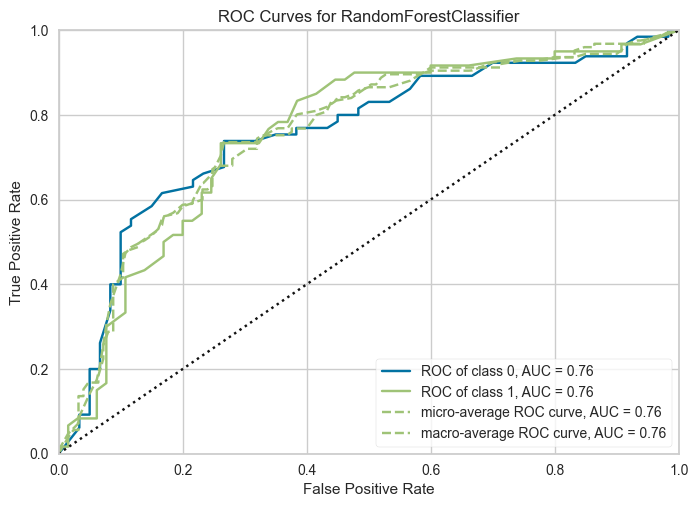

In [11]:
plot_model(best, plot='auc')

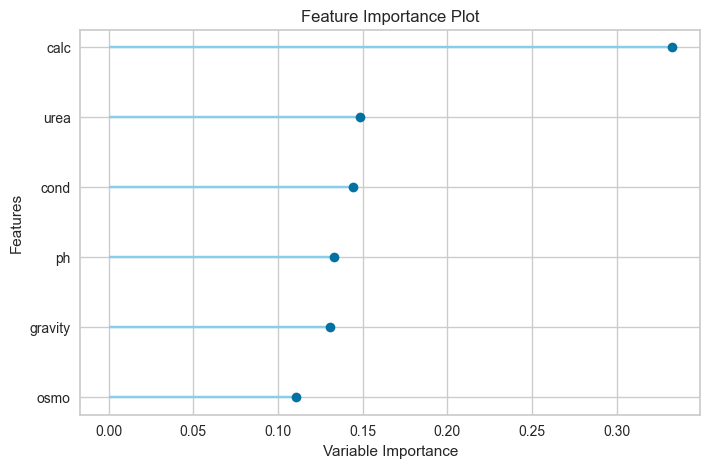

In [12]:
plot_model(best, plot='feature')

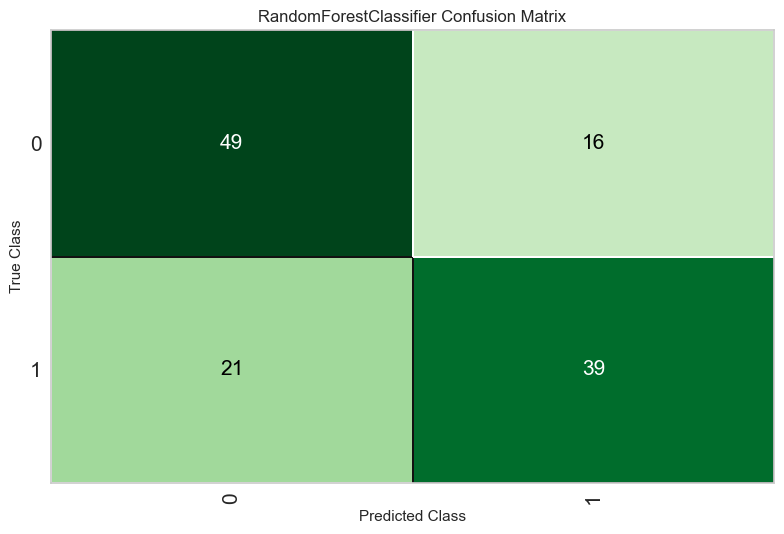

In [13]:
plot_model(best, plot='confusion_matrix')

# Hyperparameters Tuning

In [14]:
def rf(trial):
    max_depth = trial.suggest_int('max_depth', 1, 100)
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
          
    model = RandomForestClassifier(
        max_depth=max_depth,
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split
    )
    
    model.fit(X, y)
    
    cv_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)
    
    return np.mean(cv_scores)

In [15]:
def lr(trial):
    C = trial.suggest_loguniform('C', 0.001, 1000)
    solver = trial.suggest_categorical('solver', ['newton-cg', 'liblinear', 'sag', 'saga'])
    
    if solver=='sag' or solver=='newton-cg':
        penalty = 'l2'
        multi_class = trial.suggest_categorical('multi_class', ['ovr', 'multinomial'])
    elif solver=='liblinear':
        multi_class = 'ovr'
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
        if penalty==1:
            l1_ratio = trial.suggest_float(0, 1)
    elif solver=='saga':
        multi_class = trial.suggest_categorical('multi_class', ['ovr', 'multinomial'])
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
        if penalty==1:
            l1_ratio = trial.suggest_float(0, 1)
          
    model = LogisticRegression(
        C=C,
        penalty = penalty,
        solver=solver,
        multi_class=multi_class
    )
    
    model.fit(X, y)
    
    cv_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)
    
    return np.mean(cv_scores)

In [16]:
def et(trial):
    max_depth = trial.suggest_int('max_depth', 1, 100)
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', None])

          
    model = ExtraTreesClassifier(
        max_depth=max_depth,
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        max_features=max_features
    )
    
    model.fit(X, y)
    
    cv_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)
    
    return np.mean(cv_scores)

In [17]:
def lda(trial):
    solver = trial.suggest_categorical('solver', ['svd', 'lsqr', 'eigen'])
          
    model = LinearDiscriminantAnalysis(
        solver=solver
    )
    
    model.fit(X, y)
    
    cv_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)
    
    return np.mean(cv_scores)

In [18]:
# def nb(trial):
#     var_smoothing  = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-3)
          
#     model = GaussianNB(
#         var_smoothing=var_smoothing
#     )
    
#     model.fit(X, y)
    
#     cv_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)
    
#     return np.mean(cv_scores)

In [19]:
def lightgbm(trial):
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'metric': 'binary_logloss',
        'n_estimators': trial.suggest_int('n_estimators', 10, 500),
        'max_depth': trial.suggest_int('max_depth', 1, 50),
        'num_leaves': trial.suggest_int('num_leaves', 2, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-9, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-9, 10.0),
        'random_state': 0
    }

    model = LGBMClassifier(**params)

    model.fit(X, y)
    
    cv_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)
    
    return np.mean(cv_scores)

In [20]:
study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(rf, n_trials=100)
study.best_params

[I 2023-04-08 19:11:53,888] A new study created in memory with name: no-name-bf6e9fea-b293-459c-9574-b1b640708dc4


{'max_depth': 76,
 'n_estimators': 76,
 'min_samples_leaf': 1,
 'min_samples_split': 66}

In [21]:
study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(lr, n_trials=100)
study.best_params

{'C': 0.01689540303678866, 'solver': 'liblinear', 'penalty': 'l1'}

In [22]:
study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(et, n_trials=100)
study.best_params

{'max_depth': 92,
 'n_estimators': 404,
 'min_samples_leaf': 8,
 'min_samples_split': 88,
 'max_features': None}

In [23]:
study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(lda, n_trials=100)
study.best_params

{'solver': 'eigen'}

In [24]:
# study = optuna.create_study(direction='maximize')
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# study.optimize(nb, n_trials=100)
# study.best_params

In [25]:
study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(lightgbm, n_trials=100)
study.best_params

{'n_estimators': 470,
 'max_depth': 41,
 'num_leaves': 92,
 'learning_rate': 0.022085564929470447,
 'min_child_samples': 100,
 'subsample': 0.3484480261032999,
 'colsample_bytree': 0.4926344721352132,
 'reg_alpha': 1.9046392763641897,
 'reg_lambda': 5.023991061671808e-06}

In [9]:
rf_params = {
    'max_depth': 76,
    'n_estimators': 76,
    'min_samples_leaf': 1,
    'min_samples_split': 66
}

lr_params = {
    'C': 0.01689540303678866, 
    'solver': 'liblinear', 
    'penalty': 'l1'
}

et_params = {
    'max_depth': 92,
    'n_estimators': 404,
    'min_samples_leaf': 8,
    'min_samples_split': 88,
    'max_features': None
}

lda_params = {
    'solver': 'eigen'
}

lightgbm_params = {
    'n_estimators': 470,
    'max_depth': 41,
    'num_leaves': 92,
    'learning_rate': 0.022085564929470447,
    'min_child_samples': 100,
    'subsample': 0.3484480261032999,
    'colsample_bytree': 0.4926344721352132,
    'reg_alpha': 1.9046392763641897,
    'reg_lambda': 5.023991061671808e-06
}

# Bagging Ensemble

In [10]:
rf_model = RandomForestClassifier(**rf_params)
lr_model = LogisticRegression(**lr_params)
et_model = ExtraTreesClassifier(**et_params)
lda_model = LinearDiscriminantAnalysis(**lda_params)
lightgbm_model = LGBMClassifier(**lightgbm_params)

In [11]:
final_model = VotingClassifier(estimators=[('rf', rf_model), 
                                           ('et', et_model),
                                           ('lr', lr_model),
                                           ('lda', lda_model),
                                           ('lgbm', lightgbm_model)], 
                               voting='soft')

# Evaluate

In [12]:
results_ensemble = []

r_ensemble = cross_val_score(final_model, X, y, scoring='accuracy')
results_ensemble.append(r_ensemble)
print(f'Accuracy: {np.mean(results_ensemble).round(4)}')

Accuracy: 0.7414


# Model Training

In [13]:
final_model.fit(X, y)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=76,
                                                     min_samples_split=66,
                                                     n_estimators=76)),
                             ('et',
                              ExtraTreesClassifier(max_depth=92,
                                                   max_features=None,
                                                   min_samples_leaf=8,
                                                   min_samples_split=88,
                                                   n_estimators=404)),
                             ('lr',
                              LogisticRegression(C=0.01689540303678866,
                                                 penalty='l1',
                                                 solver='liblinear')),
                             ('lda',
                              LinearDiscriminantAnalysis(solver='eigen')),
          

# Prediction

In [14]:
final_predictions = final_model.predict(test)

submission = pd.concat([pd.Series(test.index, name='id'), pd.Series(final_predictions, name='target')], axis=1)
submission

,id,target
0,414,0
1,415,0
2,416,1
3,417,0
4,418,0
5,419,1
6,420,0
7,421,1
8,422,0
9,423,0


# Submission

In [15]:
submission.to_csv('submission_ensemble_model_scaled.csv', index=False)